### basic neural analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
import sklearn
from sklearn.neighbors import KernelDensity
import string
import warnings
import pickle
import json

import os
import glob
import random
from time import time


#### define spike analysis function

In [3]:
# spike analysis function
def spike_analysis(fs_spikes, total_session_time, FR_kernel, spike_clusters_data, spike_time_data):
    
    clusters_unique = np.unique(spike_clusters_data)
    nclusters = np.shape(clusters_unique)[0]

    spike_time_allclusters = dict.fromkeys(np.char.mod('%d', clusters_unique),[])
    FR_allclusters = dict.fromkeys(np.char.mod('%d', clusters_unique),[])

    for icluster in np.arange(0,nclusters,1):

        ind = spike_clusters_data == clusters_unique[icluster]

        # spike time stamps
        spike_time_icluster = spike_time_data[ind]
        spike_time_allclusters[str(clusters_unique[icluster])] = spike_time_icluster/fs_spikes # change the unit to second

        # firing rate
        xxx = spike_time_icluster
        # xxx_plot = np.linspace(0, total_session_time*fs_spikes, int(total_session_time/FR_kernel))
        xxx_plot = np.linspace(0, total_session_time*fs_spikes, int(total_session_time*fs_spikes/200))
        kde = KernelDensity(kernel="gaussian", bandwidth=FR_kernel*fs_spikes).fit(xxx.reshape(-1, 1)) # 100ms bandwith gaussian kernel
        log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
        FR_icluster = np.exp(log_dens)*fs_spikes
        
        #
        FR_allclusters[str(clusters_unique[icluster])] = FR_icluster
        
    # FR_timepoint_allclusters = xxx_plot/fs_spikes
    FR_timepoint_allclusters = xxx_plot
    
    return spike_time_allclusters,FR_timepoint_allclusters,FR_allclusters
        

## Analyze each session

### define the analysis dates

In [4]:
# define analysis dates and conditions
neural_data_folder = '/gpfs/gibbs/pi/jadi/Marmoset_neural_recording/'
neural_record_conditions = [
                            # '20231101_Dodson_withGinger_MC', 
                            # '20231101_Dodson_withGinger_SR',
                            # # '20231102_Dodson_withGinger_MC',#'20231102_Dodson_withGinger_SR',
                            # '20231103_Dodson_withGinger_MC',
                            # '20231107_Dodson_withGinger_MC',#'20231107_Dodson_withGinger_SR',
                            # '20231108_Dodson_withGinger_MC',#'20231108_Dodson_withGinger_SR',
                            # # '20231120_Dodson_withGinger_MC',#'20231120_Dodson_withGinger_SR',
                            # '20231122_Dodson_withGinger_MC',#'20231122_Dodson_withGinger_SR',
                            '20231129_Dodson_withGinger_MC',
                            # '20231129_Dodson_withGinger_SR',
                           ]
n_record_conditions = np.shape(neural_record_conditions)[0]

# define the information for bhv analysis
dates_list = [
              # '20231101_MC',
              # '20231101_SR',
              # # '20231102_MC',#'20231102_SR',
              # '20231103_MC',
              # '20231107_MC',#'20231107_SR',
              # '20231108_MC',#'20231108_SR',
              # # '20231120_MC',#'20231120_SR',
              # '20231122_MC',#'20231122_SR',
              '20231129_MC',#
              # '20231129_SR',
             ]
session_start_times_camera = [ # need to update - 12042023
                               0,  
                               # 0,
                               # # 0,  #0,
                               # 0,
                               # 0,  #0,
                               # 0,  #0,
                               # # 0,  #0,
                               # 0,  #0,
                               # 0,  
                               # 0,
                             ]
animal1_fixedorder = ['dodson']
animal2_fixedorder = ['ginger']

animal1_filename = "Dodson"
animal2_filename = "Ginger"

fs_spikes = 20000
fs_lfp = 1000

# the total time of the analyzed sessions 
total_session_time = 600 # in the unit of s

### get the basic neural data and behavioral data
### LFP analysis

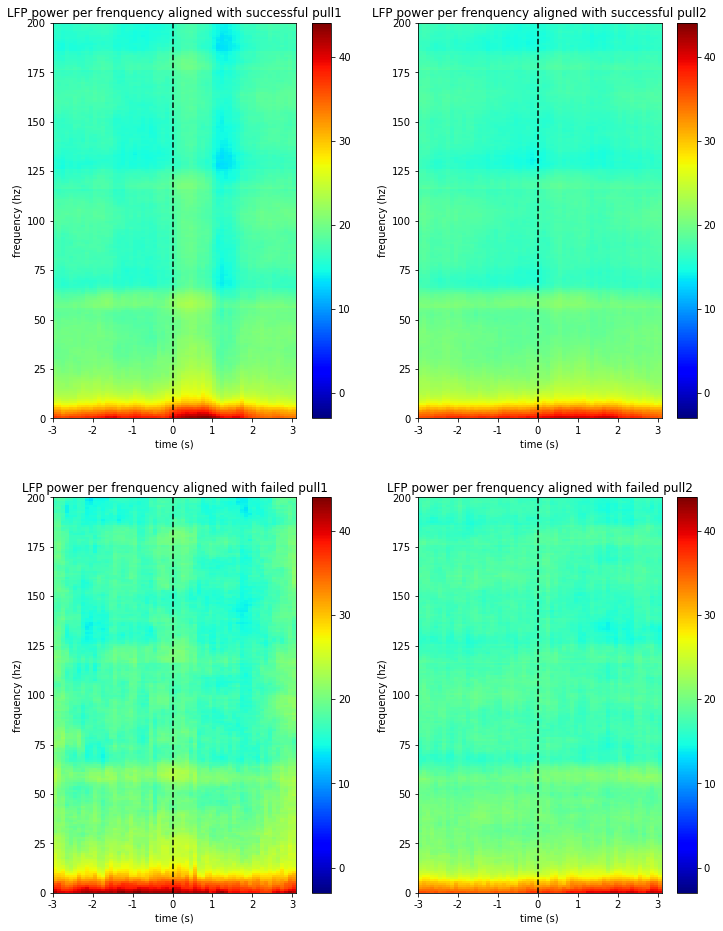

In [5]:
# plot types
plot_allpulljuice = 0
plot_succ_fail_pull = 1


# load the neural activity for each condition

for icondition in np.arange(0,n_record_conditions,1):
    
    neural_record_condition = neural_record_conditions[icondition]
    date_tgt = dates_list[icondition]
    
    # not use it for now, pre-process in matlab code first
    neural_record_filename = glob.glob(neural_data_folder+neural_record_condition+'/*.bin')[0]
    
    # # load filtered lfp
    # lfp_filt_filename = neural_data_folder+neural_record_condition+'/lfp_filt.txt'
    # lfp_filt_data_df = pd.read_csv(lfp_filt_filename)
    # mean_lfp_filt_filename = neural_data_folder+neural_record_condition+'/mean_lfp_filt.txt'
    # mean_lfp_filt_data_df = pd.read_csv(mean_lfp_filt_filename)
    
    # # load analyzed lfp - 0-200Hz power/frequency in dB
    lfp_power_filename = neural_data_folder+neural_record_condition+'/psdx_all_100msSlidingWins.txt'
    lfp_power_data = np.genfromtxt(lfp_power_filename, delimiter=",")
    lfp_power_data_df = pd.DataFrame(lfp_power_data)
    psdx_freq_filename = neural_data_folder+neural_record_condition+'/psdx_freq.txt'
    psdx_freq_data = np.genfromtxt(psdx_freq_filename, delimiter=",")
    
    #
    ntimewins = np.shape(lfp_power_data_df)[0]
    timewins = (np.array(lfp_power_data_df.columns)+0.5)*100 # in the unit of ms; use the middle of the 100ms time windows as the time point
    
    
    
    
    # load the behavioral data
    try:
        bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
        trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
        bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
        session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
        ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
        #
        trial_record = pd.read_json(trial_record_json[0])
        bhv_data = pd.read_json(bhv_data_json[0])
        session_info = pd.read_json(session_info_json[0])
        #
        with open(ni_data_json[0]) as f:
            for line in f:
                ni_data=json.loads(line)           
    except:
        bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
        trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
        bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
        session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
        ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
        #
        trial_record = pd.read_json(trial_record_json[0])
        bhv_data = pd.read_json(bhv_data_json[0])
        session_info = pd.read_json(session_info_json[0])
        #
        with open(ni_data_json[0]) as f:
            for line in f:
                ni_data=json.loads(line)

    # get animal info from the session information
    animal1_frombhv = session_info['lever1_animal'][0].lower()
    animal2_frombhv = session_info['lever2_animal'][0].lower()
    
    # get task type and cooperation threshold
    try:
        coop_thres = session_info["pulltime_thres"][0]
        tasktype = session_info["task_type"][0]
    except:
        coop_thres = 0
        tasktype = 1

    # session starting time compared with the neural recording
    session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
    neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
    neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset
    
    # align the LFP recording time stamps
    LFP_timewins_aligned = np.round((timewins+(neural_start_time_session_start_offset*fs_lfp))/100)/10 # in the unit of second
    
    # clean up the trial_record
    warnings.filterwarnings('ignore')
    trial_record_clean = pd.DataFrame(columns=trial_record.columns)
    for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
        trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
    trial_record_clean = trial_record_clean.reset_index(drop = True)

    # change bhv_data time to the absolute time
    time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
    for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        ind = bhv_data["trial_number"]==itrial+1
        new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
        time_points_new["time_points_new"][ind] = new_time_itrial
    bhv_data["time_points"] = time_points_new["time_points_new"]
    bhv_data = bhv_data[bhv_data["time_points"] != 0]
    #
    # fix misslabeled successful trial
    for itrial in np.arange(0,np.max(trial_record_clean['trial_number'])-1,1):
        #
        # initialize  
        ind = bhv_data["trial_number"]==itrial+2
        bhv_data_itrial = bhv_data[ind]
        #
        if itrial == 0:
            ind = bhv_data["trial_number"]==itrial+1
            bhv_data_pre_itrial = bhv_data[ind]
            #
            bhv_data_fixed = bhv_data_pre_itrial
        #
        # use the bhv_data_fixed for the bhv_data_pre_itrial
        #
        ind_pre_itrial = bhv_data_fixed["trial_number"]==itrial+1
        bhv_data_pre_itrial = bhv_data_fixed[ind_pre_itrial]

        # examine the itrial
        # the misslabeled successful trial, but miss one pull, need to fix 
        if np.sum((bhv_data_itrial['behavior_events']==1)|(bhv_data_itrial['behavior_events']==2))==1:
            # 
            # modify when the trial starts
            bhv_data_pre_itrial['trial_number'][bhv_data_pre_itrial['behavior_events']==9] = itrial+2
            bhv_data_pre_itrial['behavior_events'][bhv_data_pre_itrial['behavior_events']==9] = 0
            #
            # if animal 2 pull is missing
            if np.sum((bhv_data_itrial['behavior_events']==1))==1:
                # modify the animal 2 pull
                bhv_data_itrial['behavior_events'][bhv_data_itrial['behavior_events']==0] = 2
                # modify the end of previous trial
                bhv_data_pre_itrial['behavior_events'].iloc[np.where(bhv_data_pre_itrial['behavior_events']==2)[0][-1]]=9

            # if animal 1 pull is missing
            elif np.sum((bhv_data_itrial['behavior_events']==2))==1:
                # modify the animal 1 pull
                bhv_data_itrial['behavior_events'][bhv_data_itrial['behavior_events']==0] = 1
                # modify the end of previous trial
                bhv_data_pre_itrial['behavior_events'].iloc[np.where(bhv_data_pre_itrial['behavior_events']==1)[0][-1]]=9
            #
            bhv_data_fixed[ind_pre_itrial] = bhv_data_pre_itrial
            bhv_data_fixed = pd.concat([bhv_data_fixed,bhv_data_itrial])
            #
        else:
            bhv_data_fixed = pd.concat([bhv_data_fixed,bhv_data_itrial])
    bhv_data_old = bhv_data.copy()
    bhv_data = bhv_data_fixed
    
    
    # analyze behavior results
    pullid = np.array(bhv_data[(bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2)]["behavior_events"])
    pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2)]["time_points"])
    #
    juiceid = np.array(bhv_data[(bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4)]["behavior_events"])
    juicetime = np.array(bhv_data[(bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4)]["time_points"])
    #
    # successful trial
    trial_num_succ = np.array(trial_record_clean[trial_record_clean['rewarded']>0]['trial_number'])
    bhv_data_succ = bhv_data[np.isin(bhv_data['trial_number'],trial_num_succ)]
    #
    pullid_succ = np.array(bhv_data_succ[(bhv_data_succ['behavior_events']==1)|(bhv_data_succ['behavior_events']==2)]["behavior_events"])
    pulltime_succ = np.array(bhv_data_succ[(bhv_data_succ['behavior_events']==1)|(bhv_data_succ['behavior_events']==2)]["time_points"])
    #
    juiceid_succ = np.array(bhv_data_succ[(bhv_data_succ['behavior_events']==3)|(bhv_data_succ['behavior_events']==4)]["behavior_events"])
    juicetime_succ = np.array(bhv_data_succ[(bhv_data_succ['behavior_events']==3)|(bhv_data_succ['behavior_events']==4)]["time_points"])
    # 
    #failed trial
    trial_num_fail = np.array(trial_record_clean[trial_record_clean['rewarded']==0]['trial_number'])
    bhv_data_fail = bhv_data[np.isin(bhv_data['trial_number'],trial_num_fail)]
    #
    pullid_fail = np.array(bhv_data_fail[(bhv_data_fail['behavior_events']==1)|(bhv_data_fail['behavior_events']==2)]["behavior_events"])
    pulltime_fail = np.array(bhv_data_fail[(bhv_data_fail['behavior_events']==1)|(bhv_data_fail['behavior_events']==2)]["time_points"])
    #
    juiceid_fail = np.array(bhv_data_fail[(bhv_data_fail['behavior_events']==3)|(bhv_data_fail['behavior_events']==4)]["behavior_events"])
    juicetime_fail = np.array(bhv_data_fail[(bhv_data_fail['behavior_events']==3)|(bhv_data_fail['behavior_events']==4)]["time_points"])
    
    
    
    # make animal 1 as the recorded animal - dodson
    # align lfp power with pull 1 or 2; juice 1 or juice 2
    align_timewin = [-3,3] # -3s to 3s of the aligned events
    n_align_timewin = sum((LFP_timewins_aligned>=(align_timewin[0]+3)) & (LFP_timewins_aligned<=(align_timewin[1]+3)))
    n_freqs = np.shape(psdx_freq_data)[0]
    
    if animal1_frombhv == animal1_fixedorder[0]:
        # all pulls 
        npulls1 = sum(pullid==1)
        pulltimes1 = pulltime[pullid==1]
        npulls2 = sum(pullid==2)
        pulltimes2 = pulltime[pullid==2]
        # all juices
        njuice1 = sum(juiceid==3)
        juicetimes1 = juicetime[juiceid==3]
        njuice2 = sum(juiceid==4)
        juicetimes2 = juicetime[juiceid==4]
        # all succ pulls 
        npulls1_succ = sum(pullid_succ==1)
        pulltimes1_succ = pulltime_succ[pullid_succ==1]
        npulls2_succ = sum(pullid_succ==2)
        pulltimes2_succ = pulltime_succ[pullid_succ==2]
        # all fail pulls 
        npulls1_fail = sum(pullid_fail==1)
        pulltimes1_fail = pulltime_fail[pullid_fail==1]
        npulls2_fail = sum(pullid_fail==2)
        pulltimes2_fail = pulltime_fail[pullid_fail==2]
        #
    elif animal1_frombhv == animal2_fixedorder[0]:
        # all pulls 
        npulls1 = sum(pullid==2)
        pulltimes1 = pulltime[pullid==2]
        npulls2 = sum(pullid==1)
        pulltimes2 = pulltime[pullid==1]
        # all juices
        njuice1 = sum(juiceid==4)
        juicetimes1 = juicetime[juiceid==4]
        njuice2 = sum(juiceid==3)
        juicetimes2 = juicetime[juiceid==3]
        # all succ pulls 
        npulls1_succ = sum(pullid_succ==2)
        pulltimes1_succ = pulltime_succ[pullid_succ==2]
        npulls2_succ = sum(pullid_succ==1)
        pulltimes2_succ = pulltime_succ[pullid_succ==1]
        # all fail pulls 
        npulls1_fail = sum(pullid_fail==2)
        pulltimes1_fail = pulltime_fail[pullid_fail==2]
        npulls2_fail = sum(pullid_fail==1)
        pulltimes2_fail = pulltime_fail[pullid_fail==1]
        
    # all pulls and all juices
    lfp_power_pull1_aligned = np.zeros((npulls1,n_freqs,n_align_timewin))
    lfp_power_pull2_aligned = np.zeros((npulls2,n_freqs,n_align_timewin))
    lfp_power_juice1_aligned = np.zeros((njuice1,n_freqs,n_align_timewin))
    lfp_power_juice2_aligned = np.zeros((njuice2,n_freqs,n_align_timewin))
    # all successful pulls
    lfp_power_pull1_succ_aligned = np.zeros((npulls1_succ,n_freqs,n_align_timewin))
    lfp_power_pull2_succ_aligned = np.zeros((npulls2_succ,n_freqs,n_align_timewin))
    # all failed pulls
    lfp_power_pull1_fail_aligned = np.zeros((npulls1_fail,n_freqs,n_align_timewin))
    lfp_power_pull2_fail_aligned = np.zeros((npulls2_fail,n_freqs,n_align_timewin))
    #
    # all pull animal 1
    for ipull in np.arange(0,npulls1,1):
        ipulltime1 = pulltimes1[ipull]
        ipulltime1_timewin = np.round((align_timewin + ipulltime1)*10)/10
        #
        ind_LFPdata = (LFP_timewins_aligned>=ipulltime1_timewin[0]) & (LFP_timewins_aligned<=ipulltime1_timewin[1])
        lfp_power_pull1_aligned[ipull,:,:] = lfp_power_data[:,ind_LFPdata]
    #
    # all pull animal 2
    for ipull in np.arange(0,npulls2,1):
        ipulltime2 = pulltimes2[ipull]
        ipulltime2_timewin = np.round((align_timewin + ipulltime2)*10)/10       
        #
        ind_LFPdata = (LFP_timewins_aligned>=ipulltime2_timewin[0]) & (LFP_timewins_aligned<=ipulltime2_timewin[1])
        lfp_power_pull2_aligned[ipull,:,:] = lfp_power_data[:,ind_LFPdata]
    #
    # all juice animal 1
    for ijuice in np.arange(0,njuice1,1):
        ijuicetime1 = juicetimes1[ijuice]
        ijuicetime1_timewin = np.round((align_timewin + ijuicetime1)*10)/10
        #
        ind_LFPdata = (LFP_timewins_aligned>=ijuicetime1_timewin[0]) & (LFP_timewins_aligned<=ijuicetime1_timewin[1])
        lfp_power_juice1_aligned[ijuice,:,:] = lfp_power_data[:,ind_LFPdata]
    #
    # all juice animal 2
    for ijuice in np.arange(0,njuice2,1):
        ijuicetime2 = juicetimes2[ijuice]
        ijuicetime2_timewin = np.round((align_timewin + ijuicetime2)*10)/10
        #
        ind_LFPdata = (LFP_timewins_aligned>=ijuicetime2_timewin[0]) & (LFP_timewins_aligned<=ijuicetime2_timewin[1])
        lfp_power_juice2_aligned[ijuice,:,:] = lfp_power_data[:,ind_LFPdata]
    #
    # all succ pull animal 1
    for ipull in np.arange(0,npulls1_succ,1):
        ipulltime1 = pulltimes1_succ[ipull]
        ipulltime1_timewin = np.round((align_timewin + ipulltime1)*10)/10
        #
        ind_LFPdata = (LFP_timewins_aligned>=ipulltime1_timewin[0]) & (LFP_timewins_aligned<=ipulltime1_timewin[1])
        lfp_power_pull1_succ_aligned[ipull,:,:] = lfp_power_data[:,ind_LFPdata]
    lfp_power_pull1_succ_aligned[(np.isinf(lfp_power_pull1_succ_aligned))]=np.nan
    #
    # all succ pull animal 2
    for ipull in np.arange(0,npulls2_succ,1):
        ipulltime2 = pulltimes2_succ[ipull]
        ipulltime2_timewin = np.round((align_timewin + ipulltime2)*10)/10       
        #
        ind_LFPdata = (LFP_timewins_aligned>=ipulltime2_timewin[0]) & (LFP_timewins_aligned<=ipulltime2_timewin[1])
        lfp_power_pull2_succ_aligned[ipull,:,:] = lfp_power_data[:,ind_LFPdata]
    lfp_power_pull2_succ_aligned[(np.isinf(lfp_power_pull2_succ_aligned))]=np.nan
    #
    # all fail pull animal 1
    for ipull in np.arange(0,npulls1_fail,1):
        ipulltime1 = pulltimes1_fail[ipull]
        ipulltime1_timewin = np.round((align_timewin + ipulltime1)*10)/10
        #
        ind_LFPdata = (LFP_timewins_aligned>=ipulltime1_timewin[0]) & (LFP_timewins_aligned<=ipulltime1_timewin[1])
        lfp_power_pull1_fail_aligned[ipull,:,:] = lfp_power_data[:,ind_LFPdata]
    lfp_power_pull1_fail_aligned[(np.isinf(lfp_power_pull1_fail_aligned))]=np.nan
    #
    # all fail pull animal 2
    for ipull in np.arange(0,npulls2_fail,1):
        ipulltime2 = pulltimes2_fail[ipull]
        ipulltime2_timewin = np.round((align_timewin + ipulltime2)*10)/10       
        #
        ind_LFPdata = (LFP_timewins_aligned>=ipulltime2_timewin[0]) & (LFP_timewins_aligned<=ipulltime2_timewin[1])
        lfp_power_pull2_fail_aligned[ipull,:,:] = lfp_power_data[:,ind_LFPdata]        
    lfp_power_pull2_fail_aligned[(np.isinf(lfp_power_pull2_fail_aligned))]=np.nan   
    
    
    # plot the heatmap for the aligned LFP power
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(8*2)
    fig.set_figwidth(6*2)
    
    vmin = np.floor(np.nanmin([np.nanmin(lfp_power_pull1_aligned[np.isfinite(lfp_power_pull1_aligned)]),np.nanmin(lfp_power_pull2_aligned[np.isfinite(lfp_power_pull2_aligned)])]))
    vmax = np.ceil(np.nanmax([np.nanmax(np.nanmean(lfp_power_pull1_aligned,0)),np.nanmax(np.nanmean(lfp_power_pull2_aligned,0))]))
    #
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    #
    if plot_allpulljuice:
        # all pull animal 1
        im = axs[0,0].pcolormesh(np.nanmean(lfp_power_pull1_aligned,0),cmap="jet",norm=norm)
        axs[0,0].set_xticks(np.arange(0,61,10))
        axs[0,0].set_xlabel('time (s)')
        axs[0,0].set_ylabel('frequency (hz)')
        axs[0,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[0,0].plot([30,30],[0,200],'k--')
        axs[0,0].set_title('LFP power per frenquency aligned with pull1')
        fig.colorbar(im,ax=axs[0,0])
        #
        # all pull animal 2
        im = axs[0,1].pcolormesh(np.nanmean(lfp_power_pull2_aligned,0),cmap="jet",norm=norm)
        axs[0,1].set_xticks(np.arange(0,61,10))
        axs[0,1].set_xlabel('time (s)')
        axs[0,1].set_ylabel('frequency (hz)')
        axs[0,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])   
        axs[0,1].plot([30,30],[0,200],'k--')
        axs[0,1].set_title('LFP power per frenquency aligned with pull2')
        fig.colorbar(im,ax=axs[0,1])
        #
        # all juice animal 1
        im = axs[1,0].pcolormesh(np.nanmean(lfp_power_juice1_aligned,0),cmap="jet",norm=norm)
        axs[1,0].set_xticks(np.arange(0,61,10))
        axs[1,0].set_xlabel('time (s)')
        axs[1,0].set_ylabel('frequency (hz)')
        axs[1,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[1,0].plot([30,30],[0,200],'k--')
        axs[1,0].set_title('LFP power per frenquency aligned with juice1')
        fig.colorbar(im,ax=axs[1,0])
        #
        # all juice animal 2
        im = axs[1,1].pcolormesh(np.nanmean(lfp_power_juice2_aligned,0),cmap="jet",norm=norm)
        axs[1,1].set_xticks(np.arange(0,61,10))
        axs[1,1].set_xlabel('time (s)')
        axs[1,1].set_ylabel('frequency (hz)')
        axs[1,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])   
        axs[1,1].plot([30,30],[0,200],'k--')
        axs[1,1].set_title('LFP power per frenquency aligned with juice2')
        fig.colorbar(im,ax=axs[1,1])
        #
    if plot_succ_fail_pull:
        # all succ pull animal 1
        im = axs[0,0].pcolormesh(np.nanmean(lfp_power_pull1_succ_aligned,0),cmap="jet",norm=norm)
        axs[0,0].set_xticks(np.arange(0,61,10))
        axs[0,0].set_xlabel('time (s)')
        axs[0,0].set_ylabel('frequency (hz)')
        axs[0,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[0,0].plot([30,30],[0,200],'k--')
        axs[0,0].set_title('LFP power per frenquency aligned with successful pull1')
        fig.colorbar(im,ax=axs[0,0])
        #
        # all succ pull animal 2
        im = axs[0,1].pcolormesh(np.nanmean(lfp_power_pull2_succ_aligned,0),cmap="jet",norm=norm)
        axs[0,1].set_xticks(np.arange(0,61,10))
        axs[0,1].set_xlabel('time (s)')
        axs[0,1].set_ylabel('frequency (hz)')
        axs[0,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])   
        axs[0,1].plot([30,30],[0,200],'k--')
        axs[0,1].set_title('LFP power per frenquency aligned with successful pull2')
        fig.colorbar(im,ax=axs[0,1])
        #
        # all failed pull animal 1
        im = axs[1,0].pcolormesh(np.nanmean(lfp_power_pull1_fail_aligned,0),cmap="jet",norm=norm)
        axs[1,0].set_xticks(np.arange(0,61,10))
        axs[1,0].set_xlabel('time (s)')
        axs[1,0].set_ylabel('frequency (hz)')
        axs[1,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[1,0].plot([30,30],[0,200],'k--')
        axs[1,0].set_title('LFP power per frenquency aligned with failed pull1')
        fig.colorbar(im,ax=axs[1,0])
        #
        # all failed pull animal 2
        im = axs[1,1].pcolormesh(np.nanmean(lfp_power_pull2_fail_aligned,0),cmap="jet",norm=norm)
        axs[1,1].set_xticks(np.arange(0,61,10))
        axs[1,1].set_xlabel('time (s)')
        axs[1,1].set_ylabel('frequency (hz)')
        axs[1,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])   
        axs[1,1].plot([30,30],[0,200],'k--')
        axs[1,1].set_title('LFP power per frenquency aligned with failed pull2')
        fig.colorbar(im,ax=axs[1,1])

    
    savefigs = 1
    if savefigs:
        if plot_allpulljuice:
            plt.savefig(neural_data_folder+neural_record_condition+"/LFP_powerPerHz_pulljuice_aligned.pdf")   
        if plot_succ_fail_pull:
            plt.savefig(neural_data_folder+neural_record_condition+"/LFP_powerPerHz_SuccFailedpull_aligned.pdf")
    

In [6]:
bhv_data_old

,behavior_events,time_points,trial_number
0,0,6.003176,1
1,2,6.003198,1
2,2,14.059644,1
3,2,15.761175,1
4,1,17.078886,1
...,...,...,...
333,9,386.057659,55
334,0,392.558788,56
335,1,392.558789,56
336,2,394.643917,56


### spike analysis

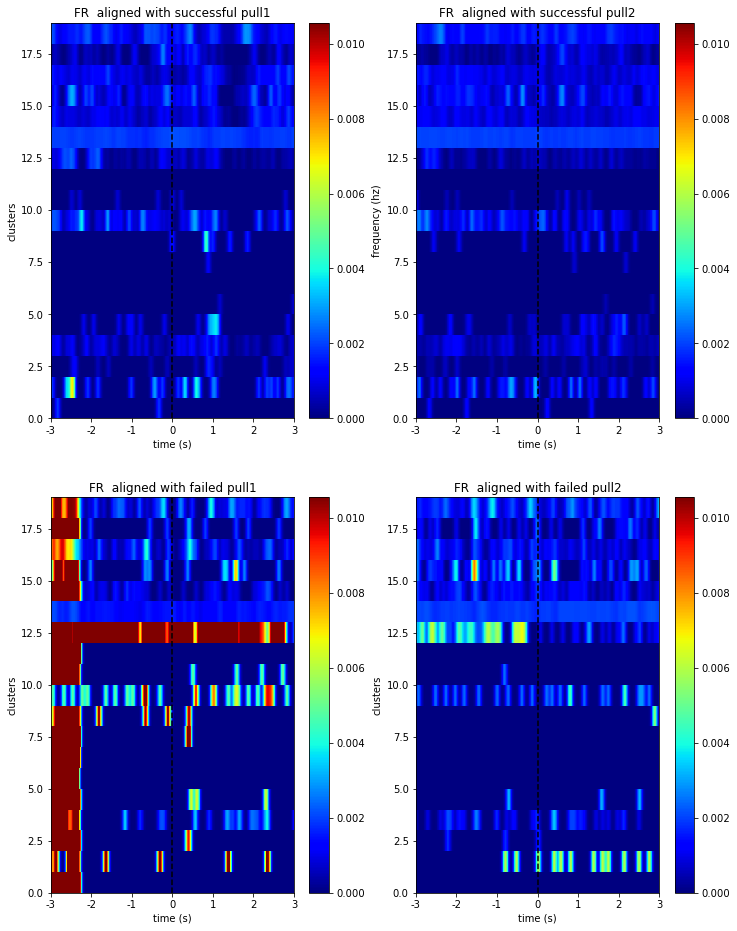

In [7]:
# plot types
plot_allpulljuice = 0
plot_succ_fail_pull = 1


# load the neural activity for each condition

for icondition in np.arange(0,n_record_conditions,1):
    
    neural_record_condition = neural_record_conditions[icondition]
    date_tgt = dates_list[icondition]
    
    # not use it for now, pre-process in matlab code first
    neural_record_filename = glob.glob(neural_data_folder+neural_record_condition+'/*.bin')[0]
    
    
    # # load spike sorting results
    spike_time_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_times.npy'
    spike_time_data = np.load(spike_time_file)
    #
    spike_clusters_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_clusters.npy'
    spike_clusters_data = np.load(spike_clusters_file)
    
    # analyze spike time
    # FR_kernel = 0.1 # 100ms gaussian kernel size
    FR_kernel = 0.05
    spike_time_allclusters,FR_timepoint_allclusters,FR_allclusters = spike_analysis(fs_spikes, total_session_time, FR_kernel, spike_clusters_data, spike_time_data)
    #
    # remove channel/cluster id
    FR_allclusters_noID = np.array(pd.DataFrame.from_dict(FR_allclusters).T)
    

    # load the behavioral data
    try:
        bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
        trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
        bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
        session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
        ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
        #
        trial_record = pd.read_json(trial_record_json[0])
        bhv_data = pd.read_json(bhv_data_json[0])
        session_info = pd.read_json(session_info_json[0])
        #
        with open(ni_data_json[0]) as f:
            for line in f:
                ni_data=json.loads(line)
            
    except:
        bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
        trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
        bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
        session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
        ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
        #
        trial_record = pd.read_json(trial_record_json[0])
        bhv_data = pd.read_json(bhv_data_json[0])
        session_info = pd.read_json(session_info_json[0])
        #
        with open(ni_data_json[0]) as f:
            for line in f:
                ni_data=json.loads(line)

    # get animal info from the session information
    animal1_frombhv = session_info['lever1_animal'][0].lower()
    animal2_frombhv = session_info['lever2_animal'][0].lower()
    
    # get task type and cooperation threshold
    try:
        coop_thres = session_info["pulltime_thres"][0]
        tasktype = session_info["task_type"][0]
    except:
        coop_thres = 0
        tasktype = 1

    # session starting time compared with the neural recording
    session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
    neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
    neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset
    
    # align the FR recording time stamps
    FR_timepoint_allclusters = FR_timepoint_allclusters + fs_spikes*neural_start_time_session_start_offset # in the unit of second
    FR_timepoint_allclusters = (np.round(FR_timepoint_allclusters*1))/1
    
    # clean up the trial_record
    warnings.filterwarnings('ignore')
    trial_record_clean = pd.DataFrame(columns=trial_record.columns)
    for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
        trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
    trial_record_clean = trial_record_clean.reset_index(drop = True)

    
    # change bhv_data time to the absolute time
    time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
    for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        ind = bhv_data["trial_number"]==itrial+1
        new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
        time_points_new["time_points_new"][ind] = new_time_itrial
    bhv_data["time_points"] = time_points_new["time_points_new"]
    bhv_data = bhv_data[bhv_data["time_points"] != 0]
    #
    # fix misslabeled successful trial
    for itrial in np.arange(0,np.max(trial_record_clean['trial_number'])-1,1):
        #
        # initialize  
        ind = bhv_data["trial_number"]==itrial+2
        bhv_data_itrial = bhv_data[ind]
        #
        if itrial == 0:
            ind = bhv_data["trial_number"]==itrial+1
            bhv_data_pre_itrial = bhv_data[ind]
            #
            bhv_data_fixed = bhv_data_pre_itrial
        #
        # use the bhv_data_fixed for the bhv_data_pre_itrial
        #
        ind_pre_itrial = bhv_data_fixed["trial_number"]==itrial+1
        bhv_data_pre_itrial = bhv_data_fixed[ind_pre_itrial]

        # examine the itrial
        # the misslabeled successful trial, but miss one pull, need to fix 
        if np.sum((bhv_data_itrial['behavior_events']==1)|(bhv_data_itrial['behavior_events']==2))==1:
            # 
            # modify when the trial starts
            bhv_data_pre_itrial['trial_number'][bhv_data_pre_itrial['behavior_events']==9] = itrial+2
            bhv_data_pre_itrial['behavior_events'][bhv_data_pre_itrial['behavior_events']==9] = 0
            #
            # if animal 2 pull is missing
            if np.sum((bhv_data_itrial['behavior_events']==1))==1:
                # modify the animal 2 pull
                bhv_data_itrial['behavior_events'][bhv_data_itrial['behavior_events']==0] = 2
                # modify the end of previous trial
                bhv_data_pre_itrial['behavior_events'].iloc[np.where(bhv_data_pre_itrial['behavior_events']==2)[0][-1]]=9

            # if animal 1 pull is missing
            elif np.sum((bhv_data_itrial['behavior_events']==2))==1:
                # modify the animal 1 pull
                bhv_data_itrial['behavior_events'][bhv_data_itrial['behavior_events']==0] = 1
                # modify the end of previous trial
                bhv_data_pre_itrial['behavior_events'].iloc[np.where(bhv_data_pre_itrial['behavior_events']==1)[0][-1]]=9
            #
            bhv_data_fixed[ind_pre_itrial] = bhv_data_pre_itrial
            bhv_data_fixed = pd.concat([bhv_data_fixed,bhv_data_itrial])
            #
        else:
            bhv_data_fixed = pd.concat([bhv_data_fixed,bhv_data_itrial])
    bhv_data_old = bhv_data.copy()
    bhv_data = bhv_data_fixed
    
    

    # analyze behavior results
    pullid = np.array(bhv_data[(bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2)]["behavior_events"])
    pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2)]["time_points"])
    #
    juiceid = np.array(bhv_data[(bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4)]["behavior_events"])
    juicetime = np.array(bhv_data[(bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4)]["time_points"])
    #
    # define successful trial
    trial_num_succ = np.array(trial_record_clean[trial_record_clean['rewarded']>0]['trial_number'])
    bhv_data_succ = bhv_data[np.isin(bhv_data['trial_number'],trial_num_succ)]
    #
    # define failed trial
    trial_num_fail = np.array(trial_record_clean[trial_record_clean['rewarded']==0]['trial_number'])
    bhv_data_fail = bhv_data[np.isin(bhv_data['trial_number'],trial_num_fail)]
    #
    # calculate successful trial
    pullid_succ = np.array(bhv_data_succ[(bhv_data_succ['behavior_events']==1)|(bhv_data_succ['behavior_events']==2)]["behavior_events"])
    pulltime_succ = np.array(bhv_data_succ[(bhv_data_succ['behavior_events']==1)|(bhv_data_succ['behavior_events']==2)]["time_points"])
    #
    juiceid_succ = np.array(bhv_data_succ[(bhv_data_succ['behavior_events']==3)|(bhv_data_succ['behavior_events']==4)]["behavior_events"])
    juicetime_succ = np.array(bhv_data_succ[(bhv_data_succ['behavior_events']==3)|(bhv_data_succ['behavior_events']==4)]["time_points"])
    # 
    #calculate failed trial
    pullid_fail = np.array(bhv_data_fail[(bhv_data_fail['behavior_events']==1)|(bhv_data_fail['behavior_events']==2)]["behavior_events"])
    pulltime_fail = np.array(bhv_data_fail[(bhv_data_fail['behavior_events']==1)|(bhv_data_fail['behavior_events']==2)]["time_points"])
    #
    juiceid_fail = np.array(bhv_data_fail[(bhv_data_fail['behavior_events']==3)|(bhv_data_fail['behavior_events']==4)]["behavior_events"])
    juicetime_fail = np.array(bhv_data_fail[(bhv_data_fail['behavior_events']==3)|(bhv_data_fail['behavior_events']==4)]["time_points"])
        
    
    
    # make animal 1 as the recorded animal - dodson
    # align FR (multiple clusters) with pull 1 or 2; juice 1 or juice 2
    align_timewin = np.array([-3,3]) * fs_spikes # -3s to 3s of the aligned events
    n_align_timewin = sum((FR_timepoint_allclusters>=(align_timewin[0]+3*fs_spikes)) & (FR_timepoint_allclusters<=(align_timewin[1]+3*fs_spikes)))
    n_clusters = np.shape(FR_allclusters_noID)[0]
    
    if animal1_frombhv == animal1_fixedorder[0]:
        # all pulls 
        npulls1 = sum(pullid==1)
        pulltimes1 = pulltime[pullid==1]
        npulls2 = sum(pullid==2)
        pulltimes2 = pulltime[pullid==2]
        # all juices
        njuice1 = sum(juiceid==3)
        juicetimes1 = juicetime[juiceid==3]
        njuice2 = sum(juiceid==4)
        juicetimes2 = juicetime[juiceid==4]
        # all succ pulls 
        npulls1_succ = sum(pullid_succ==1)
        pulltimes1_succ = pulltime_succ[pullid_succ==1]
        npulls2_succ = sum(pullid_succ==2)
        pulltimes2_succ = pulltime_succ[pullid_succ==2]
        # all fail pulls 
        npulls1_fail = sum(pullid_fail==1)
        pulltimes1_fail = pulltime_fail[pullid_fail==1]
        npulls2_fail = sum(pullid_fail==2)
        pulltimes2_fail = pulltime_fail[pullid_fail==2]
        #
    elif animal1_frombhv == animal2_fixedorder[0]:
        # all pulls 
        npulls1 = sum(pullid==2)
        pulltimes1 = pulltime[pullid==2]
        npulls2 = sum(pullid==1)
        pulltimes2 = pulltime[pullid==1]
        # all juices
        njuice1 = sum(juiceid==4)
        juicetimes1 = juicetime[juiceid==4]
        njuice2 = sum(juiceid==3)
        juicetimes2 = juicetime[juiceid==3]
        # all succ pulls 
        npulls1_succ = sum(pullid_succ==2)
        pulltimes1_succ = pulltime_succ[pullid_succ==2]
        npulls2_succ = sum(pullid_succ==1)
        pulltimes2_succ = pulltime_succ[pullid_succ==1]
        # all fail pulls 
        npulls1_fail = sum(pullid_fail==2)
        pulltimes1_fail = pulltime_fail[pullid_fail==2]
        npulls2_fail = sum(pullid_fail==1)
        pulltimes2_fail = pulltime_fail[pullid_fail==1]
        
    # all pulls and all juices
    FR_pull1_aligned = np.zeros((npulls1,n_clusters,n_align_timewin))*np.nan
    FR_pull2_aligned = np.zeros((npulls2,n_clusters,n_align_timewin))*np.nan
    FR_juice1_aligned = np.zeros((njuice1,n_clusters,n_align_timewin))*np.nan
    FR_juice2_aligned = np.zeros((njuice2,n_clusters,n_align_timewin))*np.nan
    # all successful pulls
    FR_pull1_succ_aligned = np.zeros((npulls1_succ,n_clusters,n_align_timewin))*np.nan
    FR_pull2_succ_aligned = np.zeros((npulls2_succ,n_clusters,n_align_timewin))*np.nan
    # all failed pulls
    FR_pull1_fail_aligned = np.zeros((npulls1_fail,n_clusters,n_align_timewin))*np.nan
    FR_pull2_fail_aligned = np.zeros((npulls2_fail,n_clusters,n_align_timewin))*np.nan
    #
    # all pull animal 1
    for ipull in np.arange(0,npulls1,1):
        ipulltime1 = pulltimes1[ipull] * fs_spikes
        ipulltime1_timewin = np.round((align_timewin + ipulltime1)*1)/1
        #
        ind_FRdata = (FR_timepoint_allclusters>=ipulltime1_timewin[0]) & (FR_timepoint_allclusters<=ipulltime1_timewin[1])
        FR_pull1_aligned[ipull,:,0:np.sum(ind_FRdata)] = FR_allclusters_noID[:,ind_FRdata]
    #
    # all pull animal 2
    for ipull in np.arange(0,npulls2,1):
        ipulltime2 = pulltimes2[ipull] * fs_spikes
        ipulltime2_timewin = np.round((align_timewin + ipulltime2)*1)/1       
        #
        ind_FRdata = (FR_timepoint_allclusters>=ipulltime2_timewin[0]) & (FR_timepoint_allclusters<=ipulltime2_timewin[1])
        FR_pull2_aligned[ipull,:,0:np.sum(ind_FRdata)] = FR_allclusters_noID[:,ind_FRdata]
    #
    # all juice animal 1
    for ijuice in np.arange(0,njuice1,1):
        ijuicetime1 = juicetimes1[ijuice] * fs_spikes
        ijuicetime1_timewin = np.round((align_timewin + ijuicetime1)*1)/1
        #
        ind_FRdata = (FR_timepoint_allclusters>=ijuicetime1_timewin[0]) & (FR_timepoint_allclusters<=ijuicetime1_timewin[1])
        FR_juice1_aligned[ijuice,:,0:np.sum(ind_FRdata)] = FR_allclusters_noID[:,ind_FRdata]
    #
    # all juice animal 2
    for ijuice in np.arange(0,njuice2,1):
        ijuicetime2 = juicetimes2[ijuice] * fs_spikes
        ijuicetime2_timewin = np.round((align_timewin + ijuicetime2)*1)/1
        #
        ind_FRdata = (FR_timepoint_allclusters>=ijuicetime2_timewin[0]) & (FR_timepoint_allclusters<=ijuicetime2_timewin[1])
        FR_juice2_aligned[ijuice,:,0:np.sum(ind_FRdata)] = FR_allclusters_noID[:,ind_FRdata]
    #
    # all succ pull animal 1
    for ipull in np.arange(0,npulls1_succ,1):
        ipulltime1 = pulltimes1_succ[ipull]* fs_spikes
        ipulltime1_timewin = np.round((align_timewin + ipulltime1)*1)/1
        #
        ind_FRdata = (FR_timepoint_allclusters>=ipulltime1_timewin[0]) & (FR_timepoint_allclusters<=ipulltime1_timewin[1])
        FR_pull1_succ_aligned[ipull,:,0:np.sum(ind_FRdata)] = FR_allclusters_noID[:,ind_FRdata]
    FR_pull1_succ_aligned[(np.isinf(FR_pull1_succ_aligned))]=np.nan
    #
    # all succ pull animal 2
    for ipull in np.arange(0,npulls2_succ,1):
        ipulltime2 = pulltimes2_succ[ipull] * fs_spikes
        ipulltime2_timewin = np.round((align_timewin + ipulltime2)*1)/1       
        #
        ind_FRdata = (FR_timepoint_allclusters>=ipulltime2_timewin[0]) & (FR_timepoint_allclusters<=ipulltime2_timewin[1])
        FR_pull2_succ_aligned[ipull,:,0:np.sum(ind_FRdata)] = FR_allclusters_noID[:,ind_FRdata]
    FR_pull2_succ_aligned[(np.isinf(FR_pull2_succ_aligned))]=np.nan
    #
    # all fail pull animal 1
    for ipull in np.arange(0,npulls1_fail,1):
        ipulltime1 = pulltimes1_fail[ipull]* fs_spikes
        ipulltime1_timewin = np.round((align_timewin + ipulltime1)*1)/1
        #
        ind_FRdata = (FR_timepoint_allclusters>=ipulltime1_timewin[0]) & (FR_timepoint_allclusters<=ipulltime1_timewin[1])
        FR_pull1_fail_aligned[ipull,:,0:np.sum(ind_FRdata)] = FR_allclusters_noID[:,ind_FRdata]
    FR_pull1_fail_aligned[(np.isinf(FR_pull1_fail_aligned))]=np.nan
    #
    # all fail pull animal 2
    for ipull in np.arange(0,npulls2_fail,1):
        ipulltime2 = pulltimes2_fail[ipull]* fs_spikes
        ipulltime2_timewin = np.round((align_timewin + ipulltime2)*1)/1    
        #
        ind_FRdata = (FR_timepoint_allclusters>=ipulltime2_timewin[0]) & (FR_timepoint_allclusters<=ipulltime2_timewin[1])
        FR_pull2_fail_aligned[ipull,:,0:np.sum(ind_FRdata)] = FR_allclusters_noID[:,ind_FRdata]        
    FR_pull2_fail_aligned[(np.isinf(FR_pull2_fail_aligned))]=np.nan   
    
    
    # plot the heatmap for the aligned FR
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(8*2)
    fig.set_figwidth(6*2)
    
    # vmin = np.floor(np.nanmin([np.nanmin(FR_pull1_aligned[np.isfinite(FR_pull1_aligned)]),np.nanmin(FR_pull2_aligned[np.isfinite(FR_pull2_aligned)])]))
    # vmax = np.ceil(np.nanmax([np.nanmax(np.nanmean(FR_pull1_aligned,0)),np.nanmax(np.nanmean(FR_pull2_aligned,0))]))
    vmin = (np.nanmin([np.nanmin(FR_pull1_aligned[np.isfinite(FR_pull1_aligned)]),np.nanmin(FR_pull2_aligned[np.isfinite(FR_pull2_aligned)])]))
    vmax = (np.nanmax([np.nanmax(np.nanmean(FR_pull1_aligned,0)),np.nanmax(np.nanmean(FR_pull2_aligned,0))]))
    #
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    #
    if plot_allpulljuice:
        # all pull animal 1
        im = axs[0,0].pcolormesh(np.nanmean(FR_pull1_aligned[:,:,:],0),cmap="jet",norm=norm)
        axs[0,0].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[0,0].set_xlabel('time (s)')
        axs[0,0].set_ylabel('clusters')
        axs[0,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[0,0].plot([n_align_timewin/2,n_align_timewin/2],[0,n_clusters],'k--')
        axs[0,0].set_title('FR  aligned with pull1')
        fig.colorbar(im,ax=axs[0,0])
        #
        # all pull animal 2
        im = axs[0,1].pcolormesh(np.nanmean(FR_pull2_aligned[:,:,:],0),cmap="jet",norm=norm)
        axs[0,1].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[0,1].set_xlabel('time (s)')
        axs[0,1].set_ylabel('clusters')
        axs[0,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])   
        axs[0,1].plot([n_align_timewin/2,n_align_timewin/2],[0,n_clusters],'k--')
        axs[0,1].set_title('FR  aligned with pull2')
        fig.colorbar(im,ax=axs[0,1])
        #
        # all juice animal 1
        im = axs[1,0].pcolormesh(np.nanmean(FR_juice1_aligned[:,:,:],0),cmap="jet",norm=norm)
        axs[1,0].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[1,0].set_xlabel('time (s)')
        axs[1,0].set_ylabel('clusters')
        axs[1,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[1,0].plot([n_align_timewin/2,n_align_timewin/2],[0,n_clusters],'k--')
        axs[1,0].set_title('FR  aligned with juice1')
        fig.colorbar(im,ax=axs[1,0])
        #
        # all juice animal 2
        im = axs[1,1].pcolormesh(np.nanmean(FR_juice2_aligned[:,:,:],0),cmap="jet",norm=norm)
        axs[1,1].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[1,1].set_xlabel('time (s)')
        axs[1,1].set_ylabel('frequency (hz)')
        axs[1,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])   
        axs[1,1].plot([n_align_timewin/2,n_align_timewin/2],[0,n_clusters],'k--')
        axs[1,1].set_title('FR  aligned with juice2')
        fig.colorbar(im,ax=axs[1,1])
        #
    if plot_succ_fail_pull:
        # all succ pull animal 1
        im = axs[0,0].pcolormesh(np.nanmean(FR_pull1_succ_aligned[:,:,:],0),cmap="jet",norm=norm)
        axs[0,0].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[0,0].set_xlabel('time (s)')
        axs[0,0].set_ylabel('clusters')
        axs[0,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[0,0].plot([n_align_timewin/2,n_align_timewin/2],[0,n_clusters],'k--')
        axs[0,0].set_title('FR  aligned with successful pull1')
        fig.colorbar(im,ax=axs[0,0])
        #
        # all succ pull animal 2
        im = axs[0,1].pcolormesh(np.nanmean(FR_pull2_succ_aligned[:,:,:],0),cmap="jet",norm=norm)
        axs[0,1].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[0,1].set_xlabel('time (s)')
        axs[0,1].set_ylabel('frequency (hz)')
        axs[0,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])   
        axs[0,1].plot([n_align_timewin/2,n_align_timewin/2],[0,n_clusters],'k--')
        axs[0,1].set_title('FR  aligned with successful pull2')
        fig.colorbar(im,ax=axs[0,1])
        #
        # all failed pull animal 1
        im = axs[1,0].pcolormesh(np.nanmean(FR_pull1_fail_aligned[:,:,:],0),cmap="jet",norm=norm)
        axs[1,0].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[1,0].set_xlabel('time (s)')
        axs[1,0].set_ylabel('clusters')
        axs[1,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[1,0].plot([n_align_timewin/2,n_align_timewin/2],[0,n_clusters],'k--')
        axs[1,0].set_title('FR  aligned with failed pull1')
        fig.colorbar(im,ax=axs[1,0])
        #
        # all failed pull animal 2
        im = axs[1,1].pcolormesh(np.nanmean(FR_pull2_fail_aligned[:,:,:],0),cmap="jet",norm=norm)
        axs[1,1].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[1,1].set_xlabel('time (s)')
        axs[1,1].set_ylabel('clusters')
        axs[1,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])   
        axs[1,1].plot([n_align_timewin/2,n_align_timewin/2],[0,n_clusters],'k--')
        axs[1,1].set_title('FR  aligned with failed pull2')
        fig.colorbar(im,ax=axs[1,1])

    
    savefigs = 1
    if savefigs:
        if plot_allpulljuice:
            plt.savefig(neural_data_folder+neural_record_condition+"/FR_pulljuice_aligned.pdf")   
        if plot_succ_fail_pull:
            plt.savefig(neural_data_folder+neural_record_condition+"/FR_SuccFailedpull_aligned.pdf")
    
        

    
    
        
        
        
        
        
        
        
        

#### plot some example cells 

In [ ]:
# plot types
plot_allpulljuice = 0
plot_succ_fail_pull = 1 
# 
# example for 11/01/2023
# examplecells_IDs = [10,70,8,7,76,77]
# examplecells_names = ['unit10','unit70','unit8','unit7','unit76','unit77']
examplecells_IDs = [9]
examplecells_names = ['unit9']
ncells = np.shape(examplecells_IDs)[0]

for icell in np.arange(0,ncells,1):

    cellID = examplecells_IDs[icell]
    cellname = examplecells_names[icell]
    
    # plot the aligned FR
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(6*2)
    fig.set_figwidth(6*2)
     
    # vmin = np.floor(np.nanmin([np.nanmin(FR_pull1_aligned[np.isfinite(FR_pull1_aligned)]),np.nanmin(FR_pull2_aligned[np.isfinite(FR_pull2_aligned)])]))
    # vmax = np.ceil(np.nanmax([np.nanmax(np.nanmean(FR_pull1_aligned,0)),np.nanmax(np.nanmean(FR_pull2_aligned,0))]))
    vmin = (np.nanmin([np.nanmin(FR_pull1_aligned[np.isfinite(FR_pull1_aligned)]),np.nanmin(FR_pull2_aligned[np.isfinite(FR_pull2_aligned)])]))
    vmax = (np.nanmax([np.nanmax((FR_pull1_aligned)),np.nanmax((FR_pull2_aligned))]))
    #
    if plot_allpulljuice:
        # all pull animal 1
        axs[0,0].plot(FR_pull1_aligned[:,cellID,:].T)
        axs[0,0].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[0,0].set_xlabel('time (s)')
        axs[0,0].set_ylabel('FR (Hz))')
        axs[0,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[0,0].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[0,0].set_title('FR  aligned with pull1')
        # all pull animal 2
        axs[0,1].plot(FR_pull2_aligned[:,cellID,:].T)
        axs[0,1].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[0,1].set_xlabel('time (s)')
        axs[0,1].set_ylabel('FR (Hz))')
        axs[0,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[0,1].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[0,1].set_title('FR  aligned with pull2')
        # all juice animal 1
        axs[1,0].plot(FR_juice1_aligned[:,cellID,:].T)
        axs[1,0].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[1,0].set_xlabel('time (s)')
        axs[1,0].set_ylabel('FR (Hz))')
        axs[1,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[1,0].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[1,0].set_title('FR  aligned with juice1')
        # all juice animal 2
        axs[1,1].plot(FR_juice2_aligned[:,cellID,:].T)
        axs[1,1].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[1,1].set_xlabel('time (s)')
        axs[1,1].set_ylabel('FR (Hz))')
        axs[1,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[1,1].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[1,1].set_title('FR  aligned with juice2')

        #
    if plot_succ_fail_pull:
        # all succ pull animal 1
        axs[0,0].plot(FR_pull1_succ_aligned[:,cellID,:].T)
        axs[0,0].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[0,0].set_xlabel('time (s)')
        axs[0,0].set_ylabel('FR (Hz))')
        axs[0,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[0,0].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[0,0].set_title('FR  aligned with successful pull1')
        # all succ pull animal 2
        axs[0,1].plot(FR_pull2_succ_aligned[:,cellID,:].T)
        axs[0,1].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[0,1].set_xlabel('time (s)')
        axs[0,1].set_ylabel('FR (Hz))')
        axs[0,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[0,1].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[0,1].set_title('FR  aligned with successful pull2')
        # all failed pull animal 1
        axs[1,0].plot(FR_pull1_fail_aligned[:,cellID,:].T)
        axs[1,0].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[1,0].set_xlabel('time (s)')
        axs[1,0].set_ylabel('FR (Hz))')
        axs[1,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[1,0].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[1,0].set_title('FR  aligned with failed pull1')
        # all failed pull animal 2
        axs[1,1].plot(FR_pull2_fail_aligned[:,cellID,:].T)
        axs[1,1].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[1,1].set_xlabel('time (s)')
        axs[1,1].set_ylabel('FR (Hz))')
        axs[1,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[1,1].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[1,1].set_title('FR  aligned with failed pull2')


    
savefigs = 0
if savefigs:
    if plot_allpulljuice:
        plt.savefig(neural_data_folder+neural_record_condition+"/exampleneuron_"+cellname+"_individualtrial_FR_pulljuice_aligned.pdf")   
    if plot_succ_fail_pull:
        plt.savefig(neural_data_folder+neural_record_condition+"/exampleneuron_"+cellname+"_individualtrial_FR_SuccFailedpull_aligned.pdf")
        
        
        

In [ ]:
# plot types
plot_allpulljuice = 0
plot_succ_fail_pull = 1 

examplecells_IDs = [1,9,12]
examplecells_names = ['unit1','unit9','unit12']
ncells = np.shape(examplecells_IDs)[0]

# plot the mean aligned FR
fig, axs = plt.subplots(1,ncells)
fig.set_figheight(6*1)
fig.set_figwidth(6*ncells)
    
for icell in np.arange(0,ncells,1):

    cellID = examplecells_IDs[icell]
    cellname = examplecells_names[icell]
    
    # vmin = np.floor(np.nanmin([np.nanmin(FR_pull1_aligned[np.isfinite(FR_pull1_aligned)]),np.nanmin(FR_pull2_aligned[np.isfinite(FR_pull2_aligned)])]))
    # vmax = np.ceil(np.nanmax([np.nanmax(np.nanmean(FR_pull1_aligned,0)),np.nanmax(np.nanmean(FR_pull2_aligned,0))]))
    vmin = (np.nanmin([np.nanmin(FR_pull1_aligned[np.isfinite(FR_pull1_aligned)]),np.nanmin(FR_pull2_aligned[np.isfinite(FR_pull2_aligned)])]))
    vmax = (np.nanmax([np.nanmax(np.nanmean(FR_pull1_aligned,0)),np.nanmax(np.nanmean(FR_pull2_aligned,0))]))
    #
    if plot_allpulljuice:
        # all pull animal 1
        axs[icell].plot(np.nanmean(FR_pull1_aligned[:,cellID,:],0))
        # all pull animal 2
        axs[icell].plot(np.nanmean(FR_pull2_aligned[:,cellID,:],0))
        # all juice animal 1
        axs[icell].plot(np.nanmean(FR_juice1_aligned[:,cellID,:],0))
        # all juice animal 2
        axs[icell].plot(np.nanmean(FR_juice2_aligned[:,cellID,:],0))
        #
        axs[icell].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[icell].set_xlabel('time (s)')
        axs[icell].set_ylabel('FR (Hz))')
        axs[icell].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[icell].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[icell].set_title('mean FR of example cell '+cellname)
        axs[icell].legend(['aligned pull1','aligned pull2','aligned juice1','aligned juice2'])
        #
    if plot_succ_fail_pull:
        # all succ pull animal 1
        axs[icell].plot(np.nanmean(FR_pull1_succ_aligned[:,cellID,:],0))
        # all succ pull animal 2
        axs[icell].plot(np.nanmean(FR_pull2_succ_aligned[:,cellID,:],0))
        # all failed pull animal 1
        axs[icell].plot(np.nanmean(FR_pull1_fail_aligned[:,cellID,:],0))
        # all failed pull animal 2
        axs[icell].plot(np.nanmean(FR_pull2_fail_aligned[:,cellID,:],0))
        #
        axs[icell].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[icell].set_xlabel('time (s)')
        axs[icell].set_ylabel('FR (Hz))')
        axs[icell].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[icell].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[icell].set_title('mean FR of example cell '+cellname)
        axs[icell].legend(['seccessful pull1','seccessful pull2','failed pull1','failed pull2'])


    
savefigs = 0
if savefigs:
    if plot_allpulljuice:
        plt.savefig(neural_data_folder+neural_record_condition+"/exampleneurons_FR_pulljuice_aligned.pdf")   
    if plot_succ_fail_pull:
        plt.savefig(neural_data_folder+neural_record_condition+"/exampleneurons_FR_SuccFailedpull_aligned.pdf")

#### average across all cells

In [ ]:
# plot types
plot_allpulljuice = 0
plot_succ_fail_pull = 1 
# 

# plot the aligned FR
fig, axs = plt.subplots(2,2)
fig.set_figheight(6*2)
fig.set_figwidth(6*2)

# vmin = np.floor(np.nanmin([np.nanmin(FR_pull1_aligned[np.isfinite(FR_pull1_aligned)]),np.nanmin(FR_pull2_aligned[np.isfinite(FR_pull2_aligned)])]))
# vmax = np.ceil(np.nanmax([np.nanmax(np.nanmean(FR_pull1_aligned,0)),np.nanmax(np.nanmean(FR_pull2_aligned,0))]))
vmin = (np.nanmin([np.nanmin(FR_pull1_aligned[np.isfinite(FR_pull1_aligned)]),np.nanmin(FR_pull2_aligned[np.isfinite(FR_pull2_aligned)])]))
vmax = (np.nanmax([np.nanmax(np.nanmean(FR_pull1_aligned,0)),np.nanmax(np.nanmean(FR_pull2_aligned,0))]))
#
try:
    if plot_allpulljuice:
        # all pull animal 1
        axs[0,0].plot(np.nanmean(FR_pull1_aligned[:,:,:],axis=1).T)
        axs[0,0].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[0,0].set_xlabel('time (s)')
        axs[0,0].set_ylabel('FR (Hz))')
        axs[0,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[0,0].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[0,0].set_title('FR  aligned with pull1')
        # all pull animal 2
        axs[0,1].plot(np.nanmean(FR_pull2_aligned[:,:,:],axis=1).T)
        axs[0,1].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[0,1].set_xlabel('time (s)')
        axs[0,1].set_ylabel('FR (Hz))')
        axs[0,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[0,1].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[0,1].set_title('FR  aligned with pull2')
        # all juice animal 1
        axs[1,0].plot(np.nanmean(FR_juice1_aligned[:,:,:],axis=1).T)
        axs[1,0].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[1,0].set_xlabel('time (s)')
        axs[1,0].set_ylabel('FR (Hz))')
        axs[1,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[1,0].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[1,0].set_title('FR  aligned with juice1')
        # all juice animal 2
        axs[1,1].plot(np.nanmean(FR_juice2_aligned[:,:,:],axis=1).T)
        axs[1,1].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[1,1].set_xlabel('time (s)')
        axs[1,1].set_ylabel('FR (Hz))')
        axs[1,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[1,1].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[1,1].set_title('FR  aligned with juice2')

        #
    if plot_succ_fail_pull:
        # all succ pull animal 1
        axs[0,0].plot(np.nanmean(FR_pull1_succ_aligned[:,:,:],axis=1).T)
        axs[0,0].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[0,0].set_xlabel('time (s)')
        axs[0,0].set_ylabel('FR (Hz))')
        axs[0,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[0,0].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[0,0].set_title('FR  aligned with successful pull1')
        # all succ pull animal 2
        axs[0,1].plot(np.nanmean(FR_pull2_succ_aligned[:,:,:],axis=1).T)
        axs[0,1].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[0,1].set_xlabel('time (s)')
        axs[0,1].set_ylabel('FR (Hz))')
        axs[0,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[0,1].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[0,1].set_title('FR  aligned with successful pull2')
        # all failed pull animal 1
        axs[1,0].plot(np.nanmean(FR_pull1_fail_aligned[:,:,:],axis=1).T)
        axs[1,0].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[1,0].set_xlabel('time (s)')
        axs[1,0].set_ylabel('FR (Hz))')
        axs[1,0].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[1,0].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[1,0].set_title('FR  aligned with failed pull1')
        # all failed pull animal 2
        axs[1,1].plot(np.nanmean(FR_pull2_fail_aligned[:,:,:],axis=1).T)
        axs[1,1].set_xticks(np.arange(0,n_align_timewin+1,100))
        axs[1,1].set_xlabel('time (s)')
        axs[1,1].set_ylabel('FR (Hz))')
        axs[1,1].set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs[1,1].plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs[1,1].set_title('FR  aligned with failed pull2')
except:
    print('error')

    
savefigs = 1
if savefigs:
    if plot_allpulljuice:
        plt.savefig(neural_data_folder+neural_record_condition+"/AverageNeuron_individualtrial_FR_pulljuice_aligned.pdf")   
    if plot_succ_fail_pull:
        plt.savefig(neural_data_folder+neural_record_condition+"/AverageNeuron_individualtrial_FR_SuccFailedpull_aligned.pdf")
        
        
        

In [ ]:
# plot types
plot_allpulljuice = 0
plot_succ_fail_pull = 1 

# plot the mean aligned FR
fig, axs = plt.subplots(1,1)
fig.set_figheight(6*1)
fig.set_figwidth(6*1)
    
cellname = examplecells_names[icell]

# vmin = np.floor(np.nanmin([np.nanmin(FR_pull1_aligned[np.isfinite(FR_pull1_aligned)]),np.nanmin(FR_pull2_aligned[np.isfinite(FR_pull2_aligned)])]))
# vmax = np.ceil(np.nanmax([np.nanmax(np.nanmean(FR_pull1_aligned,0)),np.nanmax(np.nanmean(FR_pull2_aligned,0))]))
vmin = (np.nanmin([np.nanmin(FR_pull1_aligned[np.isfinite(FR_pull1_aligned)]),np.nanmin(FR_pull2_aligned[np.isfinite(FR_pull2_aligned)])]))
vmax = (np.nanmax([np.nanmax(np.nanmean(FR_pull1_aligned,0)),np.nanmax(np.nanmean(FR_pull2_aligned,0))]))
#
try:
    if plot_allpulljuice:
        # all pull animal 1
        axs.plot(np.nanmean(np.nanmean(FR_pull1_aligned[:,:,:],0),0))
        # all pull animal 2
        axs.plot(np.nanmean(np.nanmean(FR_pull2_aligned[:,:,:],0),0))
        # all juice animal 1
        axs.plot(np.nanmean(np.nanmean(FR_juice1_aligned[:,:,:],0),0))
        # all juice animal 2
        axs.plot(np.nanmean(np.nanmean(FR_juice2_aligned[:,:,:],0),0))
        #
        axs.set_xticks(np.arange(0,n_align_timewin+1,100))
        axs.set_xlabel('time (s)')
        axs.set_ylabel('FR (Hz))')
        axs.set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs.plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs.set_title('mean FR of average  cell')
        axs.legend(['aligned pull1','aligned pull2','aligned juice1','aligned juice2'])
        #
    if plot_succ_fail_pull:
        # all succ pull animal 1
        axs.plot(np.nanmean(np.nanmean(FR_pull1_succ_aligned[:,:,:],0),0))
        # all succ pull animal 2
        axs.plot(np.nanmean(np.nanmean(FR_pull2_succ_aligned[:,:,:],0),0))
        # all failed pull animal 1
        axs.plot(np.nanmean(np.nanmean(FR_pull1_fail_aligned[:,:,:],0),0))
        # all failed pull animal 2
        axs.plot(np.nanmean(np.nanmean(FR_pull2_fail_aligned[:,:,:],0),0))
        #
        axs.set_xticks(np.arange(0,n_align_timewin+1,100))
        axs.set_xlabel('time (s)')
        axs.set_ylabel('FR (Hz))')
        axs.set_xticklabels([str(element) for element in np.arange(-3,4,1)])
        axs.plot([n_align_timewin/2,n_align_timewin/2],[0,vmax],'k--')
        axs.set_title('mean FR of average cell')
        axs.legend(['seccessful pull1','seccessful pull2','failed pull1','failed pull2'])
#
except:
    print('error')

    
savefigs = 1
if savefigs:
    if plot_allpulljuice:
        plt.savefig(neural_data_folder+neural_record_condition+"/AverageNeurons_FR_pulljuice_aligned.pdf")   
    if plot_succ_fail_pull:
        plt.savefig(neural_data_folder+neural_record_condition+"/AverageNeurons_FR_SuccFailedpull_aligned.pdf")